# Sample DCGAN Implementation using Keras

To illustrate the implementation of a GAN using Python, we use the [Deep Convolutional GAN](https://arxiv.org/abs/1511.06434 (DCGAN) example discussed in the Section 'Evolution of GAN Architectures' to synthesize images from the fashion MNIST dataset. 

Adapted from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

## Imports & Settings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
import sys
import numpy as np

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Dropout,
                                     BatchNormalization, Activation,
                                     ZeroPadding2D, LeakyReLU, UpSampling2D,
                                     Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [2]:
warnings.filterwarnings('ignore')

In [3]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [4]:
epochs = 2500
batch_size = 128
save_interval = 100
progress_every = 100

## Helper

In [5]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.tight_layout()
    fig.savefig('images/gan/fashion_mnist_{}.png'.format(epoch))

## Build Discriminator

Both the discriminator and generator use a deep CNN architecture, wrapped in a function:

In [6]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]),
        LeakyReLU(),
        Dropout(0.3),
        
        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),
        Flatten(),
        Dense(1)
    ])

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [7]:
# def build_discriminator():
#     model = Sequential([
#         Conv2D(32,
#                kernel_size=3,
#                strides=2,
#                input_shape=img_shape,
#                padding='same'),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.25),
#         Conv2D(64, kernel_size=3, strides=2, padding='same'),
#         ZeroPadding2D(padding=((0, 1), (0, 1))),
#         BatchNormalization(momentum=0.8),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.25),
#         Conv2D(128, kernel_size=3, strides=2, padding='same'),
#         BatchNormalization(momentum=0.8),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.25),
#         Conv2D(256, kernel_size=3, strides=1, padding='same'),
#         BatchNormalization(momentum=0.8),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.25),
#         Flatten(),
#         Dense(1, activation='sigmoid')
#     ])

#     model.summary()

#     img = Input(shape=img_shape)
#     validity = model(img)

#     return Model(img, validity)

A call to this function and subsequent compilation shows that this network has over 393,000 parameters.

In [8]:
optimizer = Adam(0.0002, 0.5)

In [9]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                           optimizer=optimizer,
                           metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

## Build Generator

The generator network is slightly shallower but has more than twice as many parameters:

In [10]:
def build_generator():
    model = Sequential([
        Dense(7 * 7 * 256, use_bias=False, input_shape=(100, )),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),
        Conv2DTranspose(128, (5, 5),
                        strides=(1, 1),
                        padding='same',
                        use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, (5, 5),
                        strides=(2, 2),
                        padding='same',
                        use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(1, (5, 5),
                        strides=(2, 2),
                        padding='same',
                        use_bias=False,
                        activation='tanh')
    ])

    model.summary()
    noise = Input(shape=(latent_dim, ))
    img = model(noise)

    return Model(noise, img)

In [11]:
# def build_generator():
#     model = Sequential([
#         Dense(128 * 7 * 7, activation=LeakyReLU(), input_dim=latent_dim),
#         Reshape((7, 7, 128)),
#         UpSampling2D(),
#         Conv2D(128, kernel_size=3, padding='same'),
#         BatchNormalization(momentum=0.8),
#         Activation('relu'),
#         UpSampling2D(),
#         Conv2D(64, kernel_size=3, padding='same'),
#         BatchNormalization(momentum=0.8),
#         Activation('relu'),
#         Conv2D(channels, kernel_size=3, padding='same'),
#         Activation('tanh')
#     ])

#     model.summary()
#     noise = Input(shape=(latent_dim, ))
#     img = model(noise)

#     return Model(noise, img)

In [12]:
# Build the generator
generator = build_generator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

## Create Combined Model

The combined model consists of the stacked generator and discriminator and trains the former to fool the latter:

In [13]:
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

## Load the Data

In [14]:
# Load the dataset
(X_train, _), (_, _) = fashion_mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

## Adversarial Training

Adversarial training iterates over the epochs, generates random image and noise input, and trains both the discriminator and the generator (as part of the combined model):

In [15]:
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

    0 | Discriminator Loss: 2.9982  Accuracy: 50.00% | Generator Loss: 4.2891
  100 | Discriminator Loss: 0.0067  Accuracy: 100.00% | Generator Loss: 0.0000
  200 | Discriminator Loss: 0.0015  Accuracy: 100.00% | Generator Loss: 0.0000
  300 | Discriminator Loss: 0.0069  Accuracy: 100.00% | Generator Loss: 0.0000
  400 | Discriminator Loss: 0.0025  Accuracy: 100.00% | Generator Loss: 15.4249
  500 | Discriminator Loss: 7.6257  Accuracy: 50.00% | Generator Loss: 0.0000
  600 | Discriminator Loss: 7.6246  Accuracy: 50.00% | Generator Loss: 0.0000
  700 | Discriminator Loss: 7.6324  Accuracy: 49.61% | Generator Loss: 0.0000
  800 | Discriminator Loss: 7.6246  Accuracy: 50.00% | Generator Loss: 0.0000
  900 | Discriminator Loss: 7.6246  Accuracy: 50.00% | Generator Loss: 0.0000
1,000 | Discriminator Loss: 7.6246  Accuracy: 50.00% | Generator Loss: 0.0000
1,100 | Discriminator Loss: 7.6246  Accuracy: 50.00% | Generator Loss: 0.0000
1,200 | Discriminator Loss: 7.6246  Accuracy: 50.00% | Gene

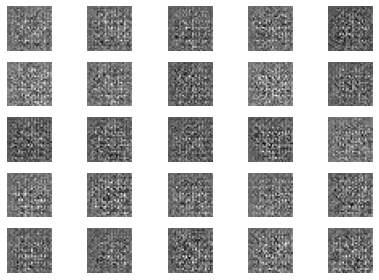

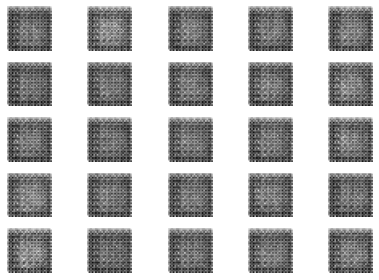

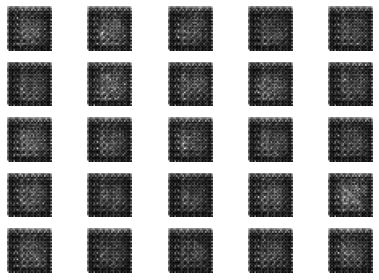

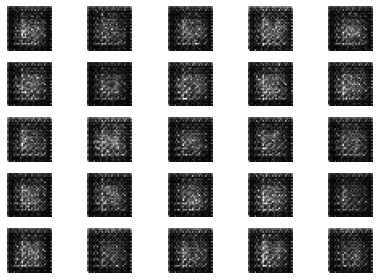

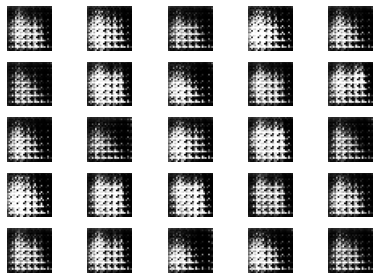

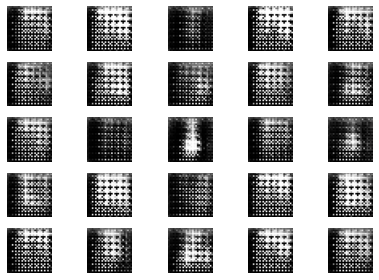

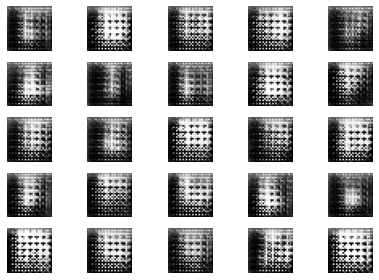

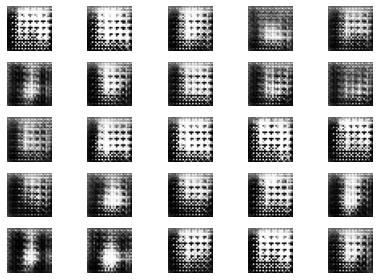

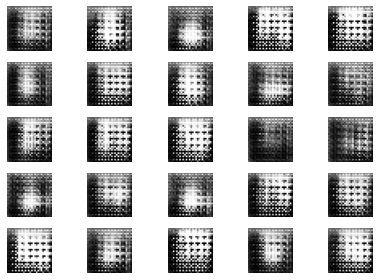

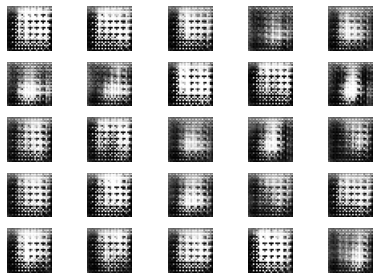

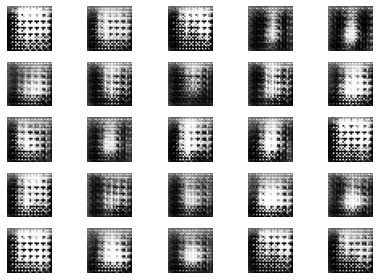

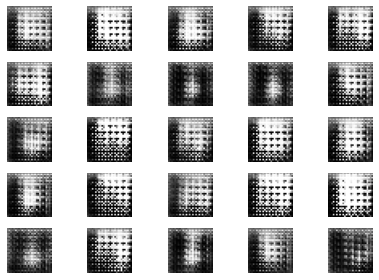

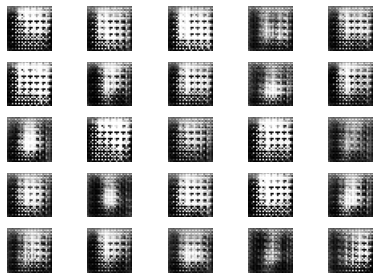

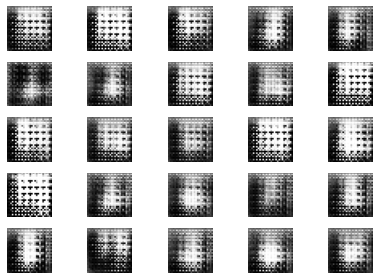

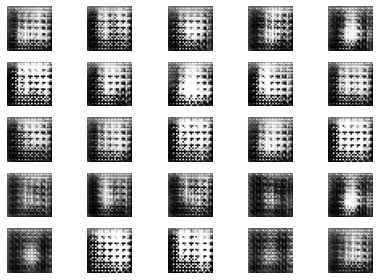

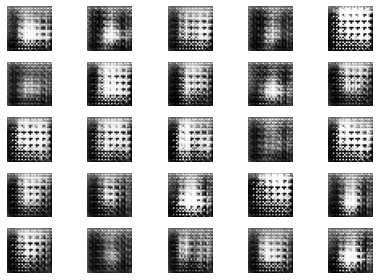

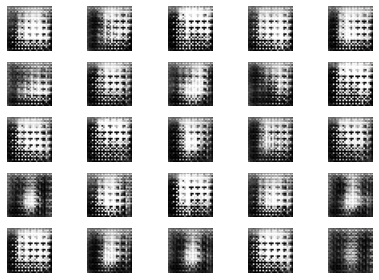

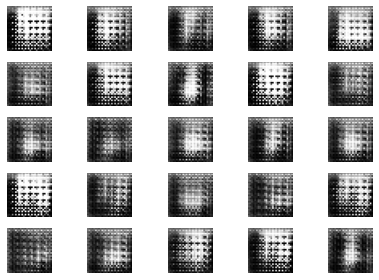

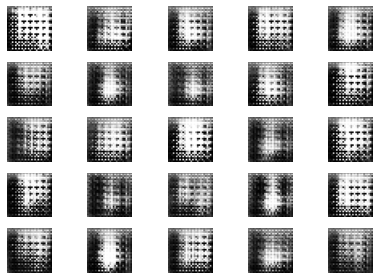

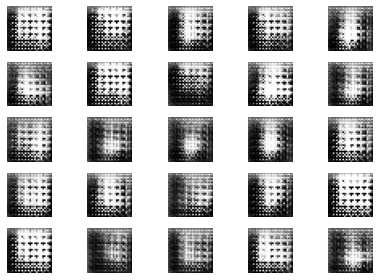

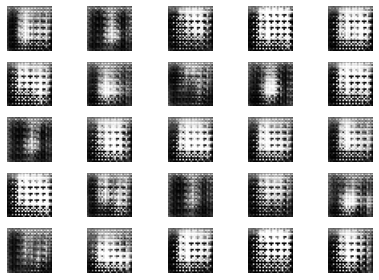

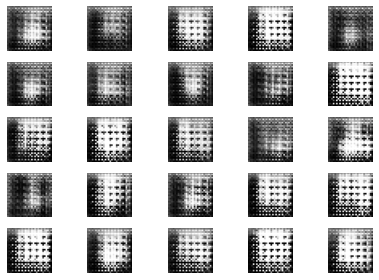

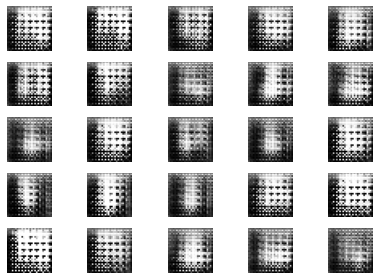

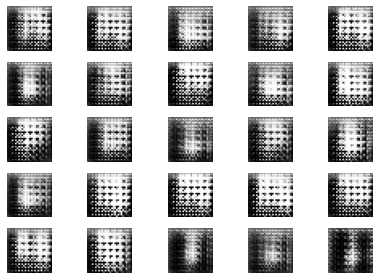

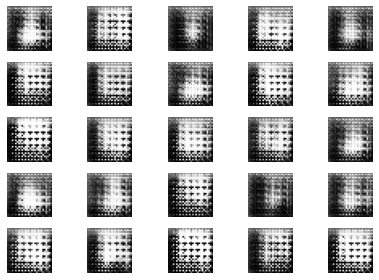

In [16]:
for epoch in range(epochs):
    # Select a random half of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    if epoch % progress_every == 0:
        output = f'{epoch:5,d} | Discriminator Loss: {d_loss[0]:.4f}  '
        output += f'Accuracy: {d_loss[1]:.2%} | Generator Loss: {g_loss:.4f}'
        print(output)

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        save_imgs(epoch)

After 10,000 epochs, which only take a few minutes, the synthetic images created from random noise clearly resemble the originals:

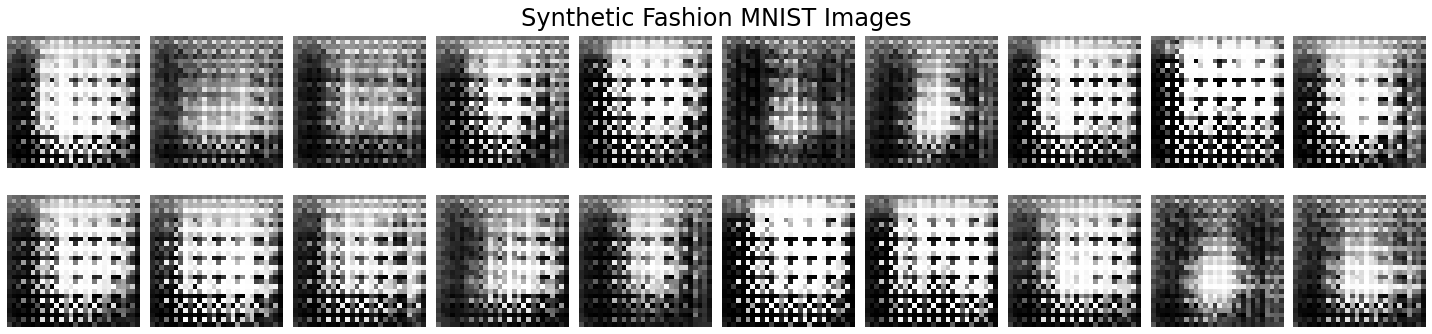

In [17]:
r, c = 2, 10
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c, figsize=(20, 5))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1

fig.suptitle('Synthetic Fashion MNIST Images', fontsize=24),
fig.tight_layout()
fig.subplots_adjust(top=.96)
fig.savefig('images/fashion_mnist.png', dpi=300)